<h1><center> Graph Transformer : forecasting hurricanes trajectories

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 65.3 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 44.7 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.2 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.4/943.4 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00


In [37]:
# Import the libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime as dt
import networkx as nx
from tqdm import tqdm
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import math

# 1- Data collection and preprocessing

In [4]:
df = pd.concat([pd.read_csv('../data/atlantic.csv'), pd.read_csv('../data/pacific.csv')]).reset_index(drop=True)
# Convert date column as datetime.
df['Date'] = pd.to_datetime(df['Date'] , format= '%Y%m%d')

In [5]:
df.columns

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW'],
      dtype='object')

In [6]:
# I want to create columns Latitude Hemisphere and Longitude Hemisphere with code 0 = N , 1 = S & 0 = E , 1 = W.
def hemisphere(coord):
        hem = re.findall(r'[NSWE]' , coord)[0]
        if hem == 'N' or hem == 'E':
            return 0
        else:
            return 1

def convert_lat_long_to_vaulue(n):
    value = float(n[:-1])
    if n[-1] == "N":
        return value
    else:
        return - value

# Creating the column Latitude_Hemisphere.
df['Latitude_Hemisphere'] = df['Latitude'].apply(hemisphere)
df['Longitude_Hemisphere'] = df['Longitude'].apply(hemisphere)
df['Latitude_Hemisphere'] = df['Latitude_Hemisphere'].astype('category')
df['Longitude_Hemisphere'] = df['Longitude_Hemisphere'].astype('category')

# Convert the latitude and longitude Column to numeric type.
df['Latitude'] =  df['Latitude'].apply(lambda x: re.match('[0-9]{1,3}.[0-9]{0,1}' , x)[0])
df['Longitude'] =   df['Longitude'].apply(lambda x: re.match('[0-9]{1,3}.[0-9]{0,1}' , x)[0])
# df['Latitude'] =  df['Latitude'].apply(convert_lat_long_to_vaulue)
# df['Longitude'] =   df['Longitude'].apply(convert_lat_long_to_vaulue)

# The missing values are given by -999. So , we need to fill them appropriately.

# Show the count of missing values and fill them with mean.
for column in df.columns:
    missing_cnt = df[column][df[column] == -999].count()
    print('Missing Values in column {col} = '.format(col = column) , missing_cnt )
    if missing_cnt!= 0:
#         print('in ' , column)
        mean = round(df[column][df[column] != -999 ].mean())
#         print("mean",mean)
        index = df.loc[df[column] == -999 , column].index
#         print("index" , index )
        df.loc[df[column] == -999 , column] = mean
#         print(df.loc[index , column])

# Restructure the dataframe for visibility and remove columns ID and Event.
df =  df[['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude', 'Latitude_Hemisphere' ,
       'Longitude', 'Longitude_Hemisphere' ,'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW']]

# Change all time to format HHMM.
df['Time'] = df['Time'].astype('object')
def hhmm(time):
    time = str(time)
    digits = re.findall(r'\d', time)
    t = ''
    if len(digits) == 1:
        t ='0{i}00'.format(i =time)
    elif len(digits) == 2:
        t = '00{i}'.format(i =time)
    elif len(digits) == 3:
        t = '0{i}'.format(i =time)
    else:
        t = time
    return t

# Apply the function.
df['Time'] = df['Time'].apply(hhmm)

# Convert the column into Datetime.
df['Time'] = pd.to_datetime(df['Time'] , format='%H%M').dt.time


# Convert the status column to categorical.
df['Status'] = df['Status'].astype('category')

data = df.drop(columns = ['ID' , 'Event'])

Missing Values in column ID =  0
Missing Values in column Name =  0
Missing Values in column Date =  0
Missing Values in column Time =  0
Missing Values in column Event =  0
Missing Values in column Status =  0
Missing Values in column Latitude =  0
Missing Values in column Longitude =  0
Missing Values in column Maximum Wind =  0
Missing Values in column Minimum Pressure =  43473
Missing Values in column Low Wind NE =  62934
Missing Values in column Low Wind SE =  62934
Missing Values in column Low Wind SW =  62934
Missing Values in column Low Wind NW =  62934
Missing Values in column Moderate Wind NE =  62934
Missing Values in column Moderate Wind SE =  62934
Missing Values in column Moderate Wind SW =  62934
Missing Values in column Moderate Wind NW =  62934
Missing Values in column High Wind NE =  62934
Missing Values in column High Wind SE =  62934
Missing Values in column High Wind SW =  62934
Missing Values in column High Wind NW =  62934
Missing Values in column Latitude_Hemisp

In [7]:
# # Add a column for scale wind speed. A range of maximum speed is associated to a category

def scale_wind_speed(speed):
    if speed < 10:
        return 0
    elif speed < 20:
        return 1
    elif speed < 30:
        return 2
    elif speed < 40:
        return 3
    elif speed < 50:
        return 4
    elif speed < 60:
        return 5
    elif speed < 70:
        return 6
    elif speed < 80:
        return 7
    elif speed < 90:
        return 8
    elif speed < 100:
        return 9
    elif speed < 110:
        return 10
    elif speed < 120:
        return 11
    elif speed < 130:
        return 12
    elif speed < 140:
        return 13
    else:
        return 14

df['Scale Wind Speed'] = df['Maximum Wind'].apply(scale_wind_speed)

In [8]:
df.head()

,ID,Name,Date,Time,Event,Status,Latitude,Latitude_Hemisphere,Longitude,Longitude_Hemisphere,...,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Scale Wind Speed
0,AL011851,UNNAMED,1851-06-25,00:00:00,,HU,28.0,0,94.8,1,...,47,19,17,12,15,7,6,4,5,8
1,AL011851,UNNAMED,1851-06-25,06:00:00,,HU,28.0,0,95.4,1,...,47,19,17,12,15,7,6,4,5,8
2,AL011851,UNNAMED,1851-06-25,12:00:00,,HU,28.0,0,96.0,1,...,47,19,17,12,15,7,6,4,5,8
3,AL011851,UNNAMED,1851-06-25,18:00:00,,HU,28.1,0,96.5,1,...,47,19,17,12,15,7,6,4,5,8
4,AL011851,UNNAMED,1851-06-25,21:00:00,L,HU,28.2,0,96.8,1,...,47,19,17,12,15,7,6,4,5,8


# 2- Graph representation

In [9]:
def weight_for_edge(i, j):
    if j == i + 1:
        return 1
    elif (j == i + 2) or (j == i + 3):
        return 0.5
    elif (j == i + 4) or (j == i + 5):
        return 0.1
    else:
        return 0

def get_local_graph(graph, node):
    graph_copy = graph.copy()
    subgraph = nx.reverse(nx.ego_graph(nx.reverse(graph_copy), node, radius=1))

    attr_node_0 = subgraph.nodes[list(subgraph.nodes)[0]]["localisation"]
    for node in subgraph.nodes:
        subgraph.nodes[node]["localisation"] = subgraph.nodes[node]["localisation"] - attr_node_0

    return subgraph

def get_dic_graph(df, loc_feature_names,wind_features, weather_feature_names, max_seq_lenght=16):
    dic_graph = {}
    dic_X = {}
    dic_Y = {}

    for hurricane in df["ID"].unique():
        df_hurr = df[df["ID"] == hurricane]

        if len(df_hurr) > 2:
            y_index = random.randint(2, len(df_hurr)-1)

            y = df_hurr[loc_feature_names].iloc[y_index].apply(float)
            y_wind = df_hurr[wind_features].iloc[y_index].apply(float)
            x = df_hurr[loc_feature_names + weather_feature_names].iloc[:y_index].iloc[-max_seq_lenght:].applymap(float)

            # Standardization of weather features
            scaler = StandardScaler()
            scaler_bis = StandardScaler()
            scaler_bis.fit(x[wind_features])
            x[weather_feature_names] = scaler.fit_transform(x[weather_feature_names])

            graph = nx.DiGraph()
            for i in range(len(x)):
                graph.add_node(i, localisation=x[loc_feature_names].values[i], weather=x[weather_feature_names].values[i])

            for i in range(len(x)):
                for j in range(i+1, len(x)):
                    if i + 5 >= j:
                        graph.add_edge(i, j, weight=weight_for_edge(i,j))

            # Localisation features to local co-ordinates
            attr_node_0 = graph.nodes[list(graph.nodes)[0]]["localisation"]
            for node in graph.nodes:
                graph.nodes[node]["localisation"] = graph.nodes[node]["localisation"] - attr_node_0

            y -= attr_node_0
            y_wind = scaler_bis.transform(pd.DataFrame(y_wind).T)
            y[wind_features[0]] = y_wind[0,0]

            # It would take approximately 1 hour to compute the local graph for all nodes.
            # for node in graph.nodes:
            #     graph.nodes[node]["subgraph"] = get_local_graph(graph, node)

            dic_graph[hurricane] = graph
            dic_X[hurricane] = x
            dic_Y[hurricane] = y

    return dic_graph, dic_X, dic_Y

## a- Stratifying

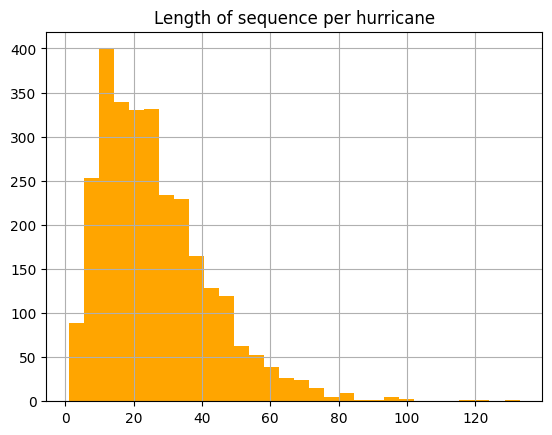

In [10]:
df.groupby("ID").count()["Date"].hist(color="orange", bins=30)
plt.title("Length of sequence per hurricane")
plt.show()

In [11]:
n_bins = 20
bins_for_stratifying = pd.cut(df.groupby("ID").count()["Date"], bins=n_bins)

bins_to_merge = bins_for_stratifying.value_counts()[bins_for_stratifying.value_counts() < 10].index
bins_for_stratifying_copy = bins_for_stratifying.copy()
good_bins = []
mapping = {}

for i in range(len(bins_for_stratifying_copy.cat.categories)):
    bin = bins_for_stratifying_copy.cat.categories[i]
    if bins_for_stratifying.value_counts()[bin] > 10:
        good_bins.append(bin)
        mapping[bin] = bin
    elif bin.left < good_bins[-1].right:
        mapping[bin] = good_bins[-1]
        pass
    else:
        bin_to_be_associated = [bin]
        number_in_bin = bins_for_stratifying.value_counts()[bin]
        to_add = True
        left = bin.left
        j = i
        while number_in_bin < 10:
            if j == len(bins_for_stratifying_copy.cat.categories)-1:
                to_add = False
                if bin.right != good_bins[-1].right:
                    good_bins[-1] = pd.Interval(good_bins[-1].left, bin.right)
                    mapping[bin] = pd.Interval(good_bins[-1].left, bin.right)
                    for bin_mapped in mapping.keys():
                        if mapping[bin_mapped].right == left:
                            mapping[bin_mapped] = pd.Interval(mapping[bin_mapped].left, bin.right)
                break
            bin = bins_for_stratifying_copy.cat.categories[j+1]
            number_in_bin += bins_for_stratifying.value_counts()[bin]
            j += 1
            bin_to_be_associated.append(bin)

        if to_add:
            right = bin.right
            good_bins.append(pd.Interval(left, right))
            for bin in bin_to_be_associated:
                mapping[bin] = pd.Interval(left, right)

bins_for_stratifying_copy = bins_for_stratifying_copy.apply(lambda x: mapping[x])

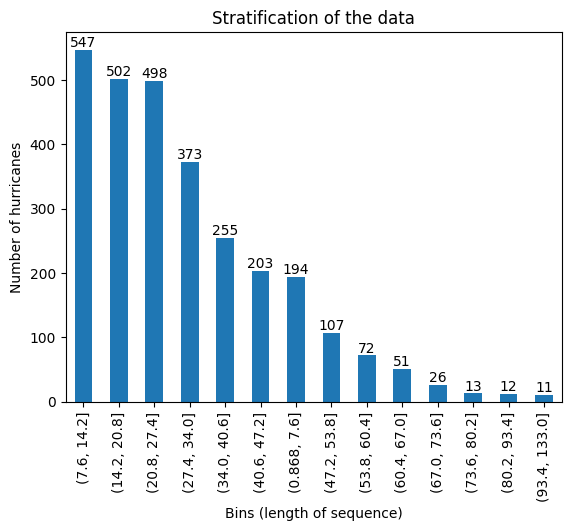

In [12]:
bins_for_stratifying_copy.value_counts().plot(kind="bar")
plt.title("Stratification of the data")
plt.xlabel("Bins (length of sequence)")
plt.ylabel("Number of hurricanes")
for i, v in enumerate(bins_for_stratifying_copy.value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()

In [13]:
hurricane_name_train, hurricane_name_test = train_test_split(bins_for_stratifying_copy, test_size=0.2, stratify=bins_for_stratifying_copy, random_state=42)
hurricane_name_val, hurricane_name_test = train_test_split(hurricane_name_test, test_size=0.5, stratify=hurricane_name_test, random_state=42)

In [14]:
df_train = df[df["ID"].isin(hurricane_name_train.index)]
df_val = df[df["ID"].isin(hurricane_name_val.index)]
df_test = df[df["ID"].isin(hurricane_name_test.index)]

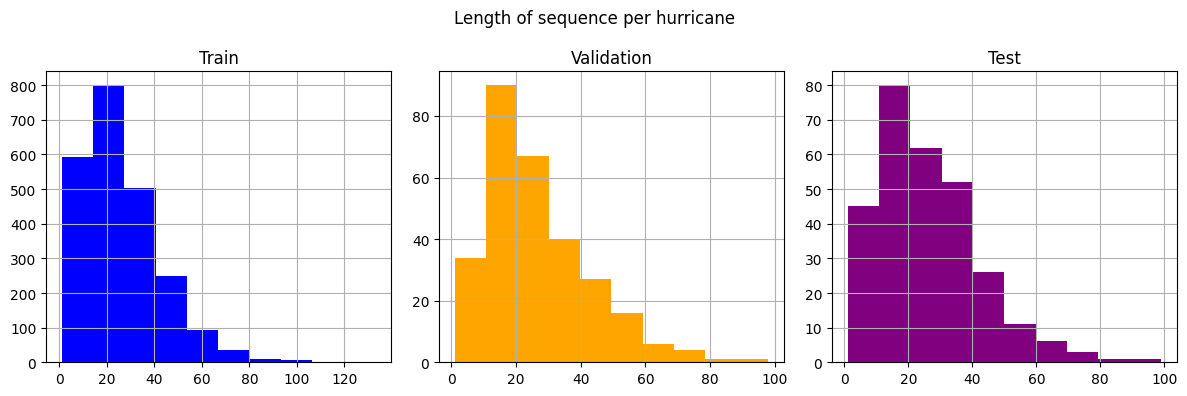

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

df_train.groupby("ID").count()["Date"].hist(ax=axs[0], color = "blue")
axs[0].set_title("Train")
df_val.groupby("ID").count()["Date"].hist(ax=axs[1], color = "orange")
axs[1].set_title("Validation")
df_test.groupby("ID").count()["Date"].hist(ax=axs[2], color = "purple")
axs[2].set_title("Test")

fig.suptitle("Length of sequence per hurricane")
fig.tight_layout()
plt.show()

In [16]:
weather_feature_names = ['Maximum Wind', 'Minimum Pressure', 'Low Wind NE', 'Low Wind SE',
       'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE', 'Moderate Wind SE',
       'Moderate Wind SW', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE',
       'High Wind SW', 'High Wind NW','Scale Wind Speed']
dic_graph_train, dic_X_train, dic_Y_train = get_dic_graph(df_train, loc_feature_names=["Latitude", "Longitude"], wind_features = ['Maximum Wind'], weather_feature_names=weather_feature_names)
dic_graph_val, dic_X_val, dic_Y_val = get_dic_graph(df_val, loc_feature_names=["Latitude", "Longitude"], wind_features = ['Maximum Wind'],weather_feature_names=weather_feature_names)
dic_graph_test, dic_X_test, dic_Y_test = get_dic_graph(df_test, loc_feature_names=["Latitude", "Longitude"], wind_features = ['Maximum Wind'],weather_feature_names=weather_feature_names)

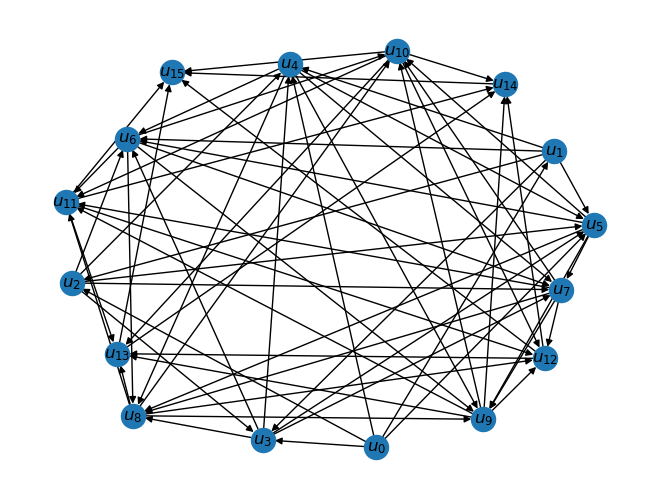

In [ ]:
graph = dic_graph_train[list(dic_graph_train.keys())[1]]
mapping = {node: "$u_{%s}$" % (node) for node in graph.nodes}
graph = nx.relabel_nodes(graph, mapping)

pos = nx.spring_layout(graph, k=10)
nx.draw(graph, pos, with_labels=True, font_weight='bold')
labels = {e: graph.edges[e]['weight'] for e in graph.edges}
# nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
plt.show()

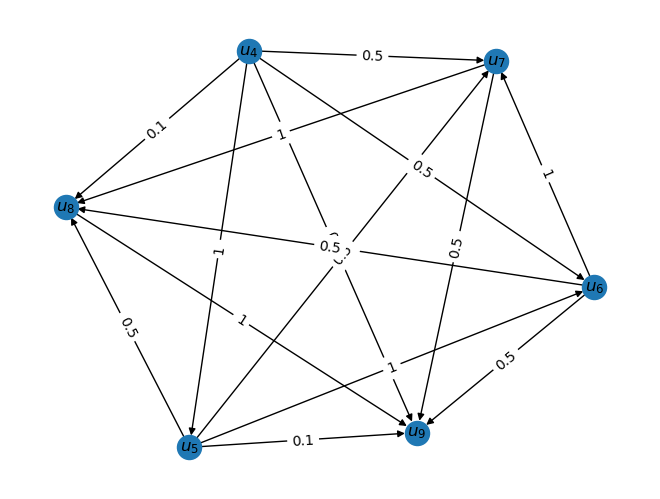

In [ ]:
graph = get_local_graph(dic_graph_train[list(dic_graph_train.keys())[1]], 9)
mapping = {node: "$u_{%s}$" % (node) for node in graph.nodes}
graph = nx.relabel_nodes(graph, mapping)

pos = nx.spring_layout(graph, k=10)
nx.draw(graph, pos, with_labels=True, font_weight='bold')
labels = {e: graph.edges[e]['weight'] for e in graph.edges}
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
plt.show()

In [ ]:
get_local_graph(dic_graph_train[list(dic_graph_train.keys())[1]], 9).nodes(data=True)

NodeDataView({4: {'localisation': array([0., 0.]), 'weather': array([1.69774938, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])}, 5: {'localisation': array([0.4, 1.7]), 'weather': array([1.69774938, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])}, 6: {'localisation': array([0.8, 3.5]), 'weather': array([-0.24253563,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])}, 7: {'localisation': array([1.3, 5. ]), 'weather': array([-1.21267813,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.     

#### Training dataset

In [17]:
def create_data_loader(dic_graph, dic_Y, batch_size, type_dataset):
    data_list = []
    for hurricane in dic_graph:
        x = torch.tensor(np.array([np.concatenate(list(dic_graph[hurricane].nodes.data()[i].values())) for i in range(len(dic_graph[hurricane].nodes))]), dtype=torch.float)

        # Convert labels to PyTorch tensor
        y = torch.tensor(dic_Y[hurricane].values, dtype=torch.float).unsqueeze(0)

        # Convert edge indices to PyTorch tensor
        edge_index = torch.tensor(list(dic_graph[hurricane].edges()),dtype=torch.long).transpose(0, 1)

        # create edge features
        edge_attr = torch.tensor([dic_graph[hurricane].edges()[edge]["weight"] for edge in dic_graph[hurricane].edges()], dtype=torch.float)

        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        data_list.append(data)

    print(f"{type_dataset} data size: {len(data_list)}")
    loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)
    return loader

In [34]:
dic_graph_train["AL011851"].nodes.data()[0]

{'localisation': array([0., 0.]),
 'weather': array([1.01997344, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.01997344])}

In [18]:
batch_size = 32

train_loader = create_data_loader(dic_graph_train, dic_Y_train, batch_size, type_dataset="Training")
val_loader = create_data_loader(dic_graph_val, dic_Y_val, batch_size, type_dataset="Validation")
test_loader = create_data_loader(dic_graph_test, dic_Y_test, batch_size, type_dataset="Test")

Training data size: 2268
Validation data size: 282
Test data size: 281


#### Calculate the Wind Scale Transition Matrix

In [19]:
# Initialize a matrix 15*15 with null values
adj = np.zeros((15, 15))
total = 0
for df_hurricane in list(dic_X_train.values()):
    for i in range(len(df_hurricane) - 1):
            # Get the max wind for row i and i+1
            wind_scale_wind_i = df_hurricane["Scale Wind Speed"].iloc[i]
            wind_scale_i_plus_1 = df_hurricane["Scale Wind Speed"].iloc[i+1]
            adj[int(wind_scale_wind_i),int(wind_scale_i_plus_1)] += 1
    total+= len(df_hurricane)
adj = adj/total
adj = adj.astype(float)
center_wind = np.array([i for i in range (5,150,10)], dtype=float).reshape(15, 1)

# 3 - Training

In [20]:
class AttentionCropFunction(torch.autograd.Function):
    @staticmethod
    def forward(self, images, locs):
        def h(_x): return 1 / (1 + torch.exp(-10 * _x.float()))
        in_size = images.size()[2]
        unit = torch.stack([torch.arange(0, in_size)] * in_size)
        x = torch.stack([unit.t()] * 1)
        y = torch.stack([unit] * 1)
        if isinstance(images, torch.cuda.FloatTensor):
            x, y = x.cuda(), y.cuda()

        in_size = images.size()[2]
        ret = []
        for i in range(images.size(0)):
            tx, ty, tl = locs[i][0], locs[i][1], locs[i][2]
            tl = tl if tl > (in_size/3) else in_size/3
            tx = tx if tx > tl else tl
            tx = tx if tx < in_size-tl else in_size-tl
            ty = ty if ty > tl else tl
            ty = ty if ty < in_size-tl else in_size-tl

            w_off = int(tx-tl) if (tx-tl) > 0 else 0
            h_off = int(ty-tl) if (ty-tl) > 0 else 0
            w_end = int(tx+tl) if (tx+tl) < in_size else in_size
            h_end = int(ty+tl) if (ty+tl) < in_size else in_size

            mk = (h(x-w_off) - h(x-w_end)) * (h(y-h_off) - h(y-h_end))
            xatt = images[i] * mk

            xatt_cropped = xatt[:, w_off: w_end, h_off: h_end]
            before_upsample = torch.autograd.Variable(xatt_cropped.unsqueeze(0))
            xamp = nn.functional.interpolate(before_upsample, size=(256, 256), mode='bilinear', align_corners=True)
            ret.append(xamp.data.squeeze())

        ret_tensor = torch.stack(ret)
        ret_tensor = torch.unsqueeze(ret_tensor, dim=1)
        self.save_for_backward(images, ret_tensor)
        return ret_tensor

    @staticmethod
    def backward(self, grad_output):
        images, ret_tensor = self.saved_tensors[0], self.saved_tensors[1]
        in_size = 256
        ret = torch.Tensor(grad_output.size(0), 3).zero_()
        norm = -(grad_output * grad_output).sum(dim=1)
        x = torch.stack([torch.arange(0, in_size)] * in_size).t()
        y = x.t()
        long_size = (in_size/3*2)
        short_size = (in_size/3)
        mx = (x >= long_size).float() - (x < short_size).float()
        my = (y >= long_size).float() - (y < short_size).float()
        ml = (((x < short_size)+(x >= long_size)+(y < short_size)+(y >= long_size)) > 0).float()*2 - 1

        mx_batch = torch.stack([mx.float()] * grad_output.size(0))
        my_batch = torch.stack([my.float()] * grad_output.size(0))
        ml_batch = torch.stack([ml.float()] * grad_output.size(0))

        if isinstance(grad_output, torch.cuda.FloatTensor):
            mx_batch = mx_batch.cuda()
            my_batch = my_batch.cuda()
            ml_batch = ml_batch.cuda()
            ret = ret.cuda()

        ret[:, 0] = (norm * mx_batch).sum(dim=1).sum(dim=1)
        ret[:, 1] = (norm * my_batch).sum(dim=1).sum(dim=1)
        ret[:, 2] = (norm * ml_batch).sum(dim=1).sum(dim=1)
        return None, ret


class AttentionCropLayer(nn.Module):
    """
        Crop function sholud be implemented with the nn.Function.
        Detailed description is in 'Attention localization and amplification' part.
        Forward function will not changed. backward function will not opearate with autograd, but munually implemented function
    """

    def forward(self, images, locs):
        return AttentionCropFunction.apply(images, locs)

In [21]:
class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=False):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features)).cuda()
        if bias:
            self.bias = nn.Parameter(torch.Tensor(1, 1, out_features)).cuda()
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)
        output = torch.matmul(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [22]:
class MultiHeadGAT(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """
    def __init__(self, in_features, out_features, dropout=0.2, alpha=0.2, num_heads=1, concat=True):
        super(MultiHeadGAT, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat
        self.num_heads = num_heads

        self.W = nn.Parameter(torch.empty(size=(self.num_heads, in_features, out_features))).cuda()
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2*out_features, 1))).cuda()
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

        self.attention_fc = nn.Linear(self.num_heads * out_features, out_features)

    def forward(self, h, adj):
        attention_result = []
        for head in range(self.num_heads):
            Wh = torch.mm(h, self.W[head]) # h.shape: (N, in_features), Wh.shape: (N, out_features)
            e = self._prepare_attentional_mechanism_input(Wh)

            zero_vec = -9e15*torch.ones_like(e)
            attention = torch.where(adj > 0, e, zero_vec)
            attention = F.softmax(attention, dim=1)
#             attention = F.dropout(attention, self.dropout, training=self.training)
            h_prime = torch.matmul(attention, Wh)

            if self.concat:
                attention_result.append(F.elu(h_prime))
            else:
                attention_result.append(h_prime)

        attention_result = torch.concat(attention_result, dim=1).cuda()
        return self.attention_fc(attention_result)


    def _prepare_attentional_mechanism_input(self, Wh):
        # Wh.shape (N, out_feature)
        # self.a.shape (2 * out_feature, 1)
        # Wh1&2.shape (N, 1)
        # e.shape (N, N)
        Wh1 = torch.matmul(Wh, self.a[:self.out_features, :])
        Wh2 = torch.matmul(Wh, self.a[self.out_features:, :])
        # broadcast add
        e = Wh1 + Wh2.T
        return self.leakyrelu(e)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [48]:
from torch_geometric.nn import GCNConv, GATv2Conv

class Model(nn.Module):
  def __init__(self, input_size_gcn, hidden_size_gcn, output_size_gcn, wind_features_size, nhead_transformer, output_size_transformer, num_layers_transformer, output_size, center_wind, adj):
    super().__init__()

    self.conv1 = GCNConv(input_size_gcn, hidden_size_gcn)
    self.conv2 = GCNConv(hidden_size_gcn, output_size_gcn)

    self.encoder_layer = nn.TransformerEncoderLayer(d_model=output_size_gcn + wind_features_size, nhead=nhead_transformer, batch_first=True)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers_transformer)
    self.fc = nn.Linear(output_size_gcn + wind_features_size, output_size_transformer)

    # self.linear = nn.Linear(output_size_transformer, output_size)

    self.elu = nn.ELU()

    # WTRG
    self.gcn1 = GraphConvolution(in_features=1, out_features=8)
    self.gcn2 = GraphConvolution(in_features=8, out_features=16)
    self.gat1 = MultiHeadGAT(in_features=16, out_features=16, num_heads=3)

    self.center_wind = center_wind
    self.adj = adj

    self.conv = nn.Conv1d(15, 1, kernel_size=3,stride=1,padding=1)


    self.combine_fc = nn.Linear(in_features=output_size_transformer+16, out_features=output_size, bias=True)

  def forward(self, x, edge_index, edge_weight):
    loc_features = x[:, :2]
    wind_features = x[:, 2:]

    # Graph convolution
    loc_features = self.conv1(loc_features, edge_index, edge_weight)
    loc_features = self.elu(loc_features)
    loc_features = self.conv2(loc_features, edge_index, edge_weight)
    loc_features = self.elu(loc_features)

    # Transformer encoder
    concatenated_input = torch.cat((loc_features, wind_features), dim=1)
    transformer_output = self.transformer_encoder(concatenated_input.unsqueeze(0))
    transformer_output = self.fc(transformer_output.squeeze())
    transformer_output = transformer_output[-1, :]  # Extract representation of the final token

    # Final linear layer
    # output = self.linear(transformer_output)
    # output = self.elu(output)

    # gcn
    gcn_out = self.gcn1(self.center_wind, self.adj)
    gcn_out = self.gcn2(gcn_out, self.adj)
    gcn_out = self.gat1(gcn_out, self.adj)
    gcn_out = torch.unsqueeze(gcn_out,dim=0)
    gcn_out = self.conv(gcn_out)
    gcn_out = torch.squeeze(gcn_out,dim=0)
    gcn_out = gcn_out[-1,:]
    #gcn_out = gcn_out.repeat(batch_size,1)

    out = torch.cat([transformer_output, gcn_out], dim=-1)
    output = self.combine_fc(out).unsqueeze(0)

    return output

In [49]:
def evaluate(model, loss_fcn, device, dataloader, batch_size):
    # loss_list_batch = []
    loss_list_batch_l = []
    loss_list_batch_w = []

    model.eval()
    for i, val_batch in enumerate(dataloader):
        val_batch = val_batch.to(device)
        output = torch.cat([model(val_batch.x[val_batch.batch==j, :],
                           val_batch.edge_index[:, (val_batch.ptr[j] <= val_batch.edge_index[0, :]) & (val_batch.edge_index[0, :] <  val_batch.ptr[j+1])] \
                           - val_batch.edge_index[:, (val_batch.ptr[j] <= val_batch.edge_index[0, :]) & (val_batch.edge_index[0, :] <  val_batch.ptr[j+1])].min(), \
                           val_batch.edge_attr[(val_batch.ptr[j] <= val_batch.edge_index[0, :]) & (val_batch.edge_index[0, :] <  val_batch.ptr[j+1])]) \
                      for j in range(val_batch.y.shape[0])], dim=0)
        # output = model(val_batch.x, val_batch.edge_index)

        #loss_test = loss_fcn(output, val_batch.y)
        loss_test_l = loss_fcn(output[:,:2], val_batch.y[:,:2])
        loss_test_w = loss_fcn(output[:,2], val_batch.y[:,2])

        #loss_list_batch.append(loss_test.item())
        loss_list_batch_l.append(loss_test_l.item())
        loss_list_batch_w.append(loss_test_w.item())

    return np.array(loss_list_batch_l).mean(), np.array(loss_list_batch_w).mean()

In [50]:
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader, batch_size, scheduler=None, lambd=0.5):

    epoch_list = []
    scores_list = []
    scores_l_list = []
    scores_w_list = []
    all_losses= []
    all_losses_l = []
    all_losses_w = []
    best_model_state_dict = None
    best_score = 0

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        losses_l = []
        losses_w = []

        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            output = torch.cat([model(train_batch_device.x[train_batch_device.batch==j, :],
                           train_batch_device.edge_index[:, (train_batch_device.ptr[j] <= train_batch_device.edge_index[0, :]) & (train_batch_device.edge_index[0, :] <  train_batch_device.ptr[j+1])] \
                           - train_batch_device.edge_index[:, (train_batch_device.ptr[j] <= train_batch_device.edge_index[0, :]) & (train_batch_device.edge_index[0, :] <  train_batch_device.ptr[j+1])].min(), \
                           train_batch_device.edge_attr[(train_batch_device.ptr[j] <= train_batch_device.edge_index[0, :]) & (train_batch_device.edge_index[0, :] <  train_batch_device.ptr[j+1])]) \
                      for j in range(train_batch_device.y.shape[0])], dim=0)
            # output = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            # loss = loss_fcn(output, train_batch_device.y)
            loss_l = loss_fcn(output[:,:2], train_batch_device.y[:,:2])
            loss_w = loss_fcn(output[:,2], train_batch_device.y[:,2])
            loss = lambd*loss_l + (1-lambd)*loss_w
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            losses_l.append(loss_l.item())
            losses_w.append(loss_w.item())

        loss_data = np.array(losses).mean()
        loss_l_data = np.array(losses_l).mean()
        loss_w_data = np.array(losses_w).mean()
        all_losses.append(loss_data)
        all_losses_l.append(loss_l_data)
        all_losses_w.append(loss_w_data)

        print("Epoch {:05d} | Loss: {:.4f} | Location Loss: {:.4f} | Wind Loss: {:.4f}".format(epoch+1, loss_data,loss_l_data, loss_w_data ))

        if scheduler is not None:
            scheduler.step()

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            score_l, score_w = evaluate(model, loss_fcn, device, val_dataloader, batch_size)
            score = lambd*score_l + (1-lambd)*score_w
            print("Loss on val set: {:.4f} and loss loc {:.4f}, loss wind {:.4f}".format(score,score_l, score_w))
            scores_list.append(score)
            scores_l_list.append(score_l)
            scores_w_list.append(score_w)
            epoch_list.append(epoch)
            # Check if the current model is the best one so far
            if score > best_score:
                best_score = score
                best_model_state_dict = model.state_dict()
    # Load the best model parameters
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)
    return epoch_list, scores_list, all_losses, scores_l_list, all_losses_l,scores_w_list, all_losses_w

In [51]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

model = Model(input_size_gcn=2,
              hidden_size_gcn=17,
              output_size_gcn=17,
              wind_features_size=next(iter(train_loader)).x.shape[1]-2,
              nhead_transformer=4,
              output_size_transformer=64,
              num_layers_transformer=4,
              output_size=3,
              center_wind=torch.tensor(center_wind, dtype=torch.float32, device=device),
              adj=torch.tensor(adj, dtype=torch.float32, device=device)).to(device)

# Define the loss function and optimizer
loss_fcn = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

max_epochs=100


Device:  cuda


In [52]:
epoch_list, scores_list, all_losses, scores_l_list, all_losses_l, scores_w_list, all_losses_w = train(model, loss_fcn, device, optimizer, max_epochs, train_loader, val_dataloader=val_loader, batch_size=32, scheduler=None, lambd=0.5)

Epoch 00001 | Loss: 3.0628 | Location Loss: 5.2282 | Wind Loss: 0.8975
Loss on val set: 2.5522 and loss loc 4.2808, loss wind 0.8235
Epoch 00002 | Loss: 2.7182 | Location Loss: 4.6701 | Wind Loss: 0.7663
Epoch 00003 | Loss: 2.4830 | Location Loss: 4.2240 | Wind Loss: 0.7420
Epoch 00004 | Loss: 2.2630 | Location Loss: 3.8030 | Wind Loss: 0.7229
Epoch 00005 | Loss: 2.0443 | Location Loss: 3.3850 | Wind Loss: 0.7035
Epoch 00006 | Loss: 1.8517 | Location Loss: 3.0069 | Wind Loss: 0.6965
Loss on val set: 1.5066 and loss loc 2.2913, loss wind 0.7219
Epoch 00007 | Loss: 1.6842 | Location Loss: 2.6799 | Wind Loss: 0.6886
Epoch 00008 | Loss: 1.5405 | Location Loss: 2.3927 | Wind Loss: 0.6882
Epoch 00009 | Loss: 1.4302 | Location Loss: 2.1760 | Wind Loss: 0.6843
Epoch 00010 | Loss: 1.3210 | Location Loss: 1.9615 | Wind Loss: 0.6806
Epoch 00011 | Loss: 1.2554 | Location Loss: 1.8363 | Wind Loss: 0.6744
Loss on val set: 1.0296 and loss loc 1.3751, loss wind 0.6841
Epoch 00012 | Loss: 1.1688 | Loca

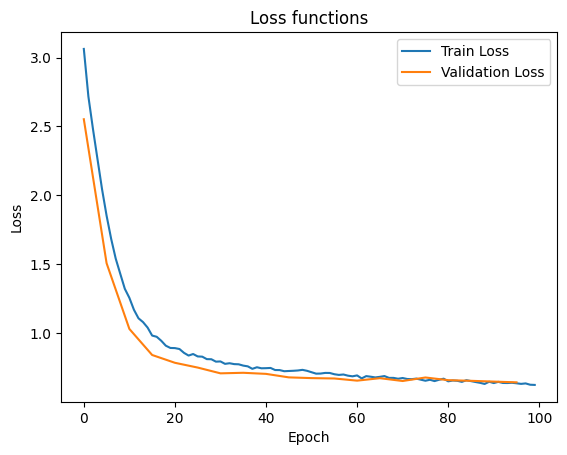

In [55]:
plt.rcParams.update(plt.rcParamsDefault)
plt.plot(all_losses, label="Train Loss")
plt.plot([i*5 for i in range(len(scores_list))], scores_list, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss functions")
plt.legend()
plt.show()

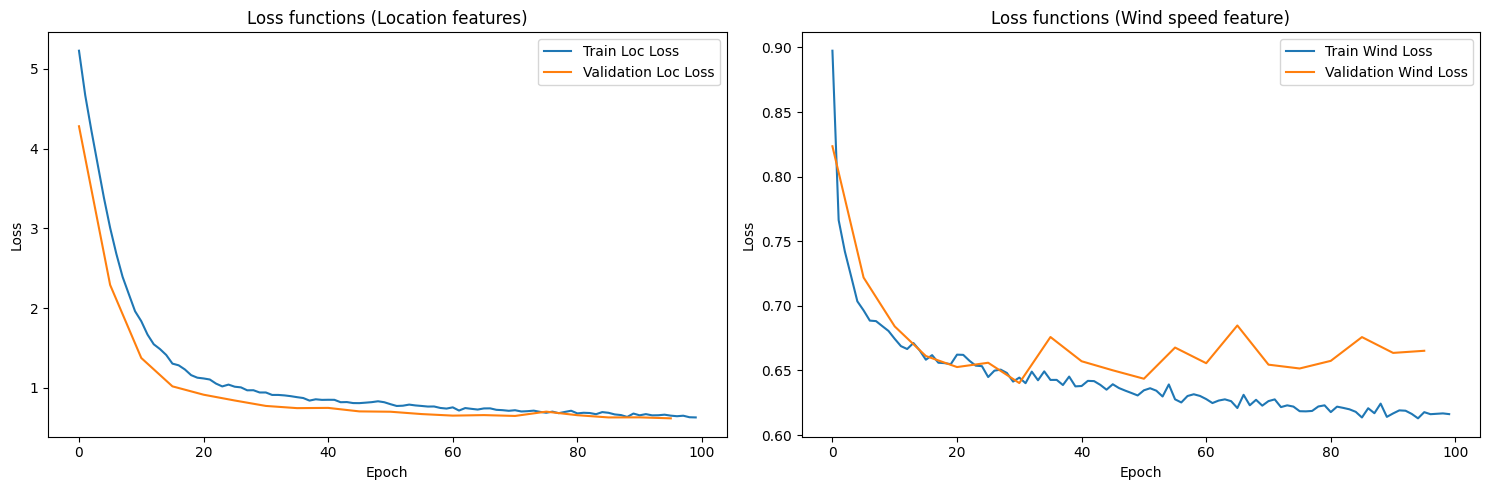

In [61]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].plot(all_losses_l, label="Train Loc Loss")
axs[0].plot([i*5 for i in range(len(scores_l_list))], scores_l_list, label="Validation Loc Loss")
axs[1].plot(all_losses_w, label="Train Wind Loss")
axs[1].plot([i*5 for i in range(len(scores_l_list))], scores_w_list, label="Validation Wind Loss")

axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss functions (Location features)")
axs[0].legend()

axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].set_title("Loss functions (Wind speed feature)")
axs[1].legend()

fig.tight_layout()
plt.show()

In [54]:
torch.save(model.state_dict(), "../models/best_model_weights_with_wind.pth")

# 4- Evaluation

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

model = Model(input_size_gcn=2,
              hidden_size_gcn=17,
              output_size_gcn=17,
              wind_features_size=next(iter(train_loader)).x.shape[1]-2,
              nhead_transformer=4,
              output_size_transformer=64,
              num_layers_transformer=4,
              output_size=3,
              center_wind=torch.tensor(center_wind, dtype=torch.float32, device=device),
              adj=torch.tensor(adj, dtype=torch.float32, device=device)).to(device)

model.load_state_dict(torch.load('best_model_weights.pth', map_location=device))


Device:  cuda


<All keys matched successfully>

In [65]:
loss_fcn = nn.SmoothL1Loss()
loss_fcn_bis = nn.L1Loss()

loss_loc, loss_wind = evaluate(model, loss_fcn, device, test_loader, batch_size)
loss_loc_bis, loss_wind_bis = evaluate(model, loss_fcn_bis, device, test_loader, batch_size)

print(f"Score with L1smooth metric on test set. Location loss: {loss_loc:.2f}, Wind speed loss: {loss_wind:.2f}")
print(f"Score with L1 metric on test set. Location loss: {loss_loc_bis:.2f}, Wind speed loss: {loss_wind_bis:.2f}")

Score with L1smooth metric on test set. Location loss: 1.02, Wind speed loss: 0.78
Score with L1 metric on test set. Location loss: 1.44, Wind speed loss: 1.10


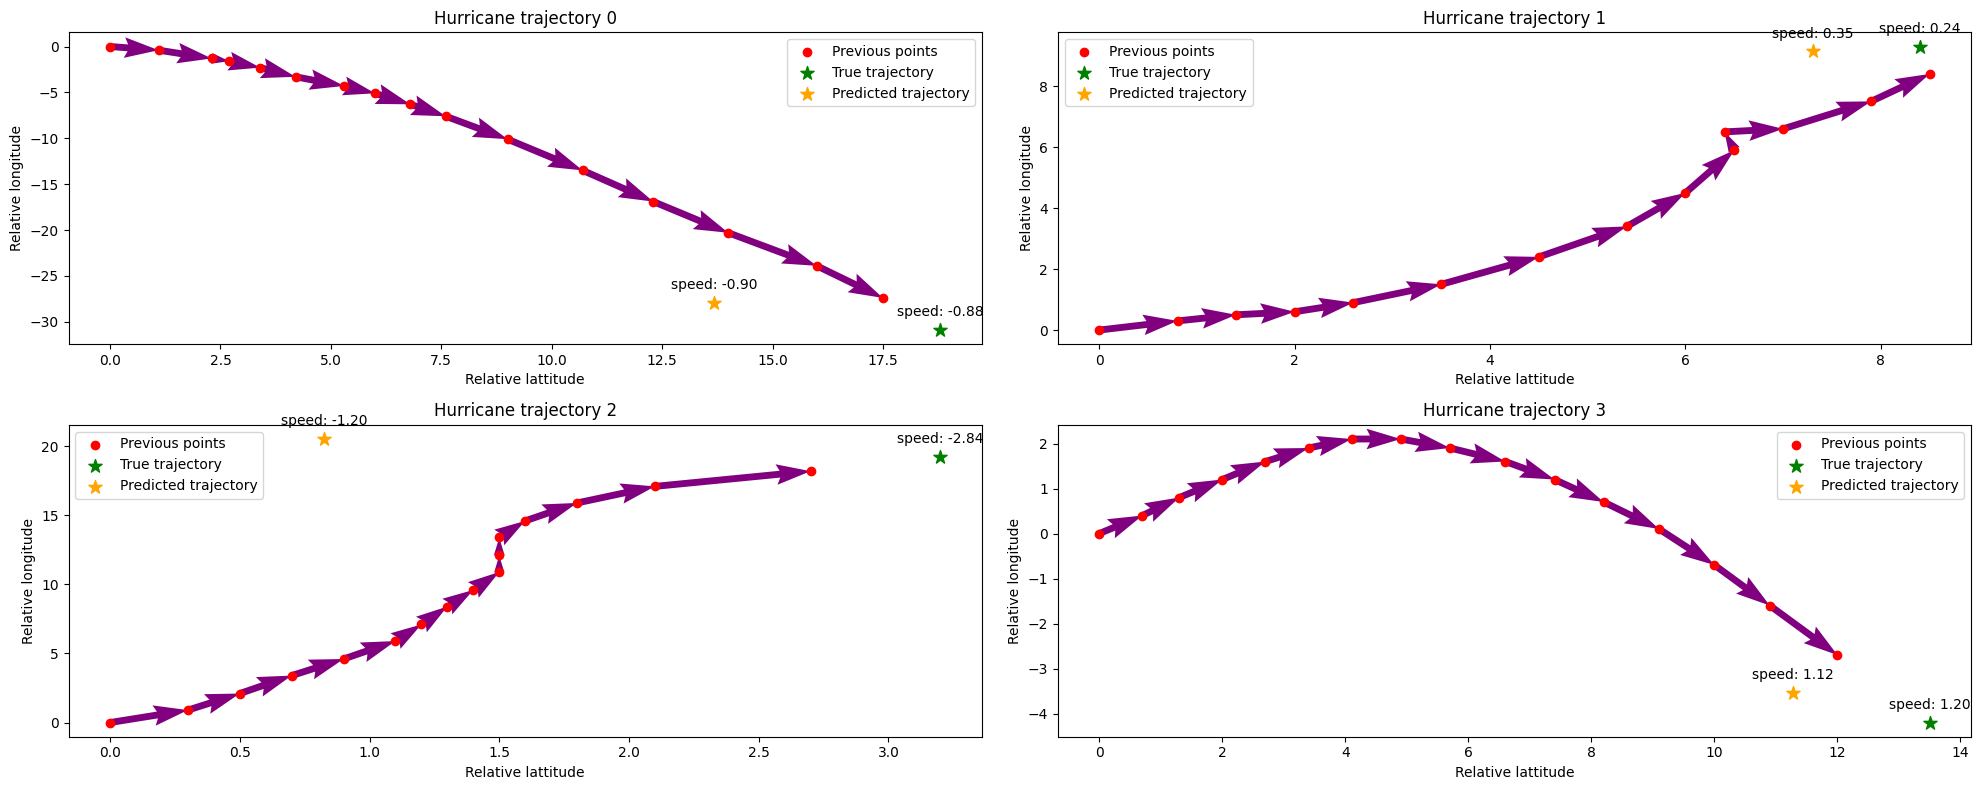

In [95]:

import matplotlib.pyplot as plt
import torch

def plot_predicted_trajectory(model, device, dataloader, batch_size, n_samples):
    model.eval()
    nb_row = 2 if n_samples>1 else 1
    fig, axs = plt.subplots(nb_row, n_samples//2, figsize=(n_samples * 5, 8))  # 5 pouces de largeur pour chaque subplot

    for i, test_batch in enumerate(dataloader):
        test_batch = test_batch.to(device)
        output = torch.cat([model(test_batch.x[test_batch.batch==j, :],
                           test_batch.edge_index[:, (test_batch.ptr[j] <= test_batch.edge_index[0, :]) & (test_batch.edge_index[0, :] <  test_batch.ptr[j+1])] \
                           - test_batch.edge_index[:, (test_batch.ptr[j] <= test_batch.edge_index[0, :]) & (test_batch.edge_index[0, :] <  test_batch.ptr[j+1])].min(), \
                           test_batch.edge_attr[(test_batch.ptr[j] <= test_batch.edge_index[0, :]) & (test_batch.edge_index[0, :] <  test_batch.ptr[j+1])]) \
                      for j in range(test_batch.y.shape[0])], dim=0)
        break

    for i in range(n_samples):
        prev_points = test_batch.x[test_batch.batch == i, :].cpu().detach().numpy()

        if n_samples == 1:
            ax = axs
        else:
            if i < n_samples//2:
                ax = axs[0, i]
            else:
                ax = axs[1, i - n_samples//2]

        for j in range(len(prev_points)-1):
            ax.quiver(prev_points[j, 0], prev_points[j, 1],
                      prev_points[j+1, 0] - prev_points[j, 0], prev_points[j+1, 1] - prev_points[j, 1],
                      angles='xy', scale_units='xy', scale=1, color='purple')

        ax.scatter(prev_points[:, 0], prev_points[:, 1], label="Previous points", color="red")
        ax.scatter(test_batch.y[i].cpu().detach().numpy()[0], test_batch.y[i].cpu().detach().numpy()[1], label="True trajectory", color = "green", marker = '*', s=100)
        ax.scatter(output[i].cpu().detach().numpy()[0], output[i].cpu().detach().numpy()[1], label="Predicted trajectory",color = "orange",marker = '*', s=100)
        ax.annotate(f"speed: {test_batch.y[i].cpu().detach().numpy()[2]:.2f}", (test_batch.y[i].cpu().detach().numpy()[0], test_batch.y[i].cpu().detach().numpy()[1]), textcoords="offset points", xytext=(0,10), ha="center")
        ax.annotate(f"speed: {output[i].cpu().detach().numpy()[2]:.2f}", (output[i].cpu().detach().numpy()[0], output[i].cpu().detach().numpy()[1]), textcoords="offset points", xytext=(0,10), ha="center")

        ax.set_xlabel("Relative lattitude")
        ax.set_ylabel("Relative longitude")

        ax.legend()
        ax.title.set_text(f"Hurricane trajectory {i}")

    plt.tight_layout()
    plt.show()


plot_predicted_trajectory(model, device, test_loader, batch_size, n_samples=4)

In [ ]:
# faire un plot de l'erreur en fonction du nombre de point en amont du cyclone

def lat_long_error(ground_truth, predicted):
    return np.sqrt((ground_truth[0] - predicted[0])**2 + (ground_truth[1] - predicted[1])**2)

# 5- Hierarchical agregation and cumulative errors